# First Task

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import logging 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() \
                      else "cpu")
print("working on: " + str(DEVICE))

working on: cuda


In [4]:
RANDOM_SEED = 20200101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# reproducibility with convolutions (btw, we do not use them)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
DB = pd.read_csv("./pmsm_temperature_data.csv")
DBs = [db[1] for db in DB.groupby("profile_id")]
# np.random.shuffle(DBs)
print(DB.shape)
print(len(DBs))

(998070, 13)
52


In [6]:
DB.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [7]:
TARGET = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]
FEATURES = ["ambient", "coolant", "u_d", "u_q", "motor_speed", "i_d", "i_q"]

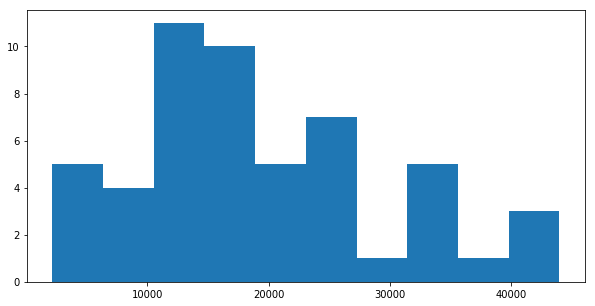

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(list(map(len, DBs)))
plt.show()

In [9]:
val_list = [20, 31, 46, 54, 62, 70, 79, 72]
test_list = [36, 42]
train_list = [df["profile_id"].iloc[0] for df in DBs
              if df["profile_id"].iloc[0] not in val_list + test_list]
 
TRAIN_SET = [df[FEATURES + TARGET]
             for df in DBs
             if df["profile_id"].iloc[0] in train_list]
VAL_SET   = [df[FEATURES + TARGET]
             for df in DBs
             if df["profile_id"].iloc[0] in val_list]
TEST_SET  = [df[FEATURES + TARGET]
             for df in DBs
             if df["profile_id"].iloc[0] in test_list]

assert len(TRAIN_SET + TEST_SET + VAL_SET) == len(DBs)
assert len(train_list) == len(TRAIN_SET)
assert len(val_list) == len(VAL_SET)
assert len(test_list) == len(TEST_SET)

print(len(TRAIN_SET), len(VAL_SET), len(TEST_SET))

42 8 2


In [10]:
def normalize(data):
    X = pd.concat(data)
    min = X.min()
    range = X.max() - min
    return lambda df: (df - min) / range

In [11]:
tensor_normalizer = lambda df: \
    torch.from_numpy(train_normalizer(df).values).float().to(DEVICE)

train_normalizer = normalize(TRAIN_SET)
TRAIN_SET_TENSOR = [tensor_normalizer(df) for df in TRAIN_SET]
VAL_SET_TENSOR =   [tensor_normalizer(df) for df in VAL_SET]
TEST_SET_TENSOR =  [tensor_normalizer(df) for df in TEST_SET]

# Neural Networks

In [12]:
BATCH_SIZE = 512
EPOCHS = 50

In [13]:
def plot_history(history):
    train_col = "red"
    test_col = "orange"
    for feature in ["loss"] + ["R2_" + t for t in TARGET]:
        plt.plot(history["_".join([feature, "train"])],
                 label="Train",
                 color=train_col)
        plt.plot(history["_".join([feature, "test"])],
                 label="Test",
                 color=test_col)
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.title(feature)
        plt.legend()
        plt.show()

In [14]:
def predict(mod, serie, t0):
    Y_total = []
    Yhat_total = []
    mod.eval()
    for i in range(t0, len(serie)):
        # X = serie[(i - t0):(i + 1), :len(FEATURES)]  # new task
        X = serie[(i - t0):i, :]  # old task
        y = serie[i, len(FEATURES):]
        y_hat = mod(X.reshape((1,) + X.shape))
        Y_total.append(y)
        Yhat_total.append(y_hat)
    return torch.stack(Y_total).cpu().detach().numpy(), \
        torch.stack(Yhat_total).cpu().detach().numpy()


def print_predictions(mod, serie, t0):
    y, y_hat = predict(mod, serie, t0)
    for i, t in enumerate(TARGET):
        plt.plot(y[:, i], color="black",
                 label="Real")
        plt.plot(y_hat[:, 0, i], color="red",
                 label="Prevision")
        plt.xlabel("time")
        plt.ylabel(t)
        plt.legend()
        plt.show()

In [15]:
def dataloader(data, length, batch_size=BATCH_SIZE, shuffle=True):
    tuples = [[(df_i, i) for i in range(len(df)) if i > length]
              for df_i, df in enumerate(data)]
    tuples = sum(tuples, [])  # flattenize

    # shuffle
    if shuffle:
        np.random.shuffle(tuples)

    lim, Lim = 0, batch_size
    while lim < len(tuples):
        sample = tuples[lim:min(Lim, len(tuples))]
        # X = torch.stack([data[df_i][(i-length):(i+1), :len(FEATURES)]  # new task
        X = torch.stack([data[df_i][(i-length):i, :]  # old task
                         for df_i, i in sample])
        Y = torch.stack([data[df_i][i, len(FEATURES):] \
                         for df_i, i in sample])
        yield X, Y
        lim, Lim = Lim, Lim + batch_size

In [16]:
def R2(x, y):
    return np.corrcoef(x, y)[0, 1]**2


def evaluate(mod, loss_fn, data, length, batch_size):
    "Return loss and R² of the model given some data"

    # it set the model to evaluation mode (stop dropout and so on)
    mod.eval()

    # resutls for the whole evaluation procedure (return values)
    loss_total = []
    Y_total = []
    Yhat_total = []
    batch_size_total = []

    for X, Y in dataloader(data,
                           length=length,
                           batch_size=batch_size,
                           shuffle=False):
        Y_hat = mod(X)
        loss = loss_fn(Y_hat, Y)
        loss_total.append(loss.cpu().item())
        Y_total.append(Y.cpu().detach().numpy())
        Yhat_total.append(Y_hat.cpu().detach().numpy())
        batch_size_total.append(len(Y))

    Y_total = np.vstack(Y_total)
    Yhat_total = np.vstack(Yhat_total)
    _, p = Y_total.shape

    R2_total = [R2(Y_total[:, i], Yhat_total[:, i]) for i in range(p)]
    return np.average(loss_total, weights=batch_size_total), R2_total


def stop_early(patience_max, times_max=1):
    "Return a earl stopping checker"
    # (from: Goodfellow & Bengio)
    patience = 0
    times = 0
    min_loss = np.Inf

    def check(loss):
        "Return if the train process must stop early"
        nonlocal patience, times, min_loss
        if loss >= min_loss:
            patience += 1
            if patience >= patience_max:
                patience = 0
                times += 1
                if times >= times_max:
                    return True
        else:
            min_loss = loss
            patience = 0
        return False
    return check

In [17]:
def train(mod, loss_fn, optimizer,
          train_set, test_set,
          previous_size,
          epochs=EPOCHS, batch_size=BATCH_SIZE,
          early_stopping=None,
          verbose=True):
    "Train the model"

    R2_strings = ["_".join(["R2", t, s])
                  for t in TARGET
                  for s in ["train", "test"]]
    # history of the train process
    history = {label: [] for label in R2_strings}
    history["time"] = []
    history["loss_train"] = []
    history["loss_test"] = []

    # repeat for tot epochs
    for epoch in range(epochs):

        # it set the model in train mode (start dropout)
        mod.train()

        # just to know how much does it take
        start = datetime.now()

        for X, Y in dataloader(train_set,
                               length=previous_size,
                               batch_size=batch_size):
            optimizer.zero_grad()             # reset gradient
            Y_hat = mod(X)                    # make predictions!
            loss = loss_fn(Y_hat, Y)          # compute loss
            loss.backward()                   # calc direction of GD
            optimizer.step()                  # do a little step to the optimum

        time = datetime.now() - start  # ok, it lasts tot (always too much) seconds

        # just compute and store results
        history["time"].append(time)

    
        loss, r2 = evaluate(mod, loss_fn, train_set, previous_size, batch_size)
        history["loss_train"].append(loss)
        for c, rho in zip(TARGET, r2):
            history["R2_" + c + "_train"].append(rho)

        loss, r2 = evaluate(mod, loss_fn, test_set, previous_size, batch_size)
        history["loss_test"].append(loss)
        for c, rho in zip(TARGET, r2):
            history["R2_" + c + "_test"].append(rho)
        
        # print how good is our model
        if verbose:
            print(epoch + 1, end="\t")
            print(str(time), end="\t")
            for val in ["loss"] + ["R2_" + t for t in TARGET]:
                print(val, end=": ")
                print("(%.3f, %.3f)" % (history[val + "_train"][-1],
                                        history[val + "_test"][-1]),
                      end="\t")
            print("", end="\r")
        
        # stop the process if it start to degenerate
        if early_stopping is not None and early_stopping(history["loss_test"][-1]):
            break

    return history

# Recurrent NN

In [18]:
class Custom_RNN(torch.nn.Module):

    def __init__(self, hiddens, recur,
                 regressors,
                 p_dropout=0.3):
        self.recur_input, self.recur_output = recur
        # recur_input in [0, len(hiddens))
        # recur_output in [-1, len(hiddens)]
        assert 0 <= self.recur_input <= len(hiddens)
        assert -1 <= self.recur_output < len(hiddens)
        assert len(regressors) == 2

        super(Custom_RNN, self).__init__()
        # input_shape = len(FEATURES)  # new task
        input_shape = len(FEATURES) + len(TARGET)  # old task
        self.previous_size = hiddens[self.recur_output] \
            if self.recur_output >= 0 else len(TARGET)
        
        hiddens_in = [input_shape] + hiddens

        hiddens_in[self.recur_input] += self.previous_size

        self.dropout = torch.nn.Dropout(p=p_dropout)
        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_shape, out_shape) \
             for in_shape, out_shape in zip(hiddens_in, hiddens)])
        self.layers_fn = [torch.nn.functional.relu \
                          for _ in self.layers]

        regressor_list = []
        for features, regressor in zip([1, 3], regressors):
            if type(regressor) != list:
                regressor = [regressor]
            input_shape = [hiddens[-1]] + regressor
            y_net = [torch.nn.ReLU() for _ in input_shape + regressor]
            y_net[::2] = [torch.nn.Linear(in_shape, out_shape)
                          for in_shape, out_shape
                          in zip(input_shape, regressor + [features])]
            regressor_list.append(torch.nn.Sequential(*y_net))
        self.regressors = torch.nn.ModuleList(regressor_list)

    def initialize_prev(self, x):
        return torch.zeros(len(x), self.previous_size).to(DEVICE)

    def forward(self, data, lag=None):
        _, l, _ = data.shape
        x = data[:, 0, :]  # .reshape(-1, len(FEATURES))
        if lag is None:  # first recursion
            lag = self.initialize_prev(x)
        for i, (layer, fn) in enumerate(zip(self.layers, self.layers_fn)):
            if i == self.recur_input:
                x = torch.cat([x, lag], axis=1)
            x = fn(layer(x))
            x = self.dropout(x)
            if i == self.recur_output and l > 1:
                return self.forward(data[:, 1:, :], x)
        x = torch.cat([regressor(x) for regressor in self.regressors],
                      axis=1)
        if self.recur_output == -1 and l > 1:
            return self.forward(data[:, 1:, :], x)
        return x

# Ottimizzazione

In [19]:
import sherpa
import os

In [20]:
def optimize(train_set, test_set, loss_fn, file_end, epochs=100):
    hiddens = [
        sherpa.Discrete("hidden", [5, 40])]
    recur = [
        sherpa.Discrete("input_rec",  [0,  len(hiddens)]),
        sherpa.Discrete("output_rec", [-1, len(hiddens) - 1])]
    regressors = [
        sherpa.Discrete("hidden1_pm",     [3, 20]),
        sherpa.Discrete("hidden2_pm",     [3, 20]),
        sherpa.Discrete("hidden1_stator", [3, 20]),
        sherpa.Discrete("hidden2_stator", [3, 20])]
    others = [
        sherpa.Discrete("window", [1, 30]),
        sherpa.Continuous("lr", [1e-2, 1e-7])]
    parameters = hiddens + recur + regressors + others
    
    best_score = np.Inf
    best_model = None

    alg = sherpa.algorithms.bayesian_optimization.GPyOpt(
        max_concurrent=1,
        model_type="GP",
        acquisition_type="EI",
        max_num_trials=epochs)

    study = sherpa.Study(parameters=parameters,
                         algorithm=alg,
                         lower_is_better=True,
                         disable_dashboard=True)

    for i, trial in enumerate(study):
        mod = Custom_RNN([int(trial.parameters["hidden"])],
                         (int(trial.parameters["input_rec"]),
                          int(trial.parameters["output_rec"])),
                         [[int(trial.parameters["hidden1_pm"]),
                           int(trial.parameters["hidden2_pm"])],
                          [int(trial.parameters["hidden1_stator"]),
                           int(trial.parameters["hidden1_stator"])]]).to(DEVICE)

        optimizer = torch.optim.Adam(params=mod.parameters(),
                                     lr=trial.parameters["lr"])

        loss = train(mod, loss_fn, optimizer,
                     train_set, test_set,
                     epochs=2, verbose=False,
                     previous_size=int(trial.parameters["window"]))["loss_test"][-1]

        print(i + 1, "%.5f" % loss, end="\r", sep="\t")
        if loss < best_score:
            best_model = mod.cpu()
            best_score = loss
            torch.save(best_model.cpu(), "./models/best_model_rnn_" + file_end)
            print("")
    
        study.add_observation(trial, iteration=1, objective=loss)
        study.finalize(trial)
        study.results.to_csv("./results/AutoML_RNN_{}.csv".format(file_end))

    return best_model.to(DEVICE)

In [20]:
def print_optimization_results(train_set, test_set, filename,
                               epochs=100, loss_fn=torch.nn.MSELoss(),
                               force_retrain=False):
    log_file = "./results/AutoML_RNN_{}.csv".format(filename)
    model_file = "./models/best_model_rnn_" + filename
    print_log = True
    if force_retrain or \
       not (os.path.isfile(log_file) and os.path.isfile(model_file)):
        best_model = optimize(train_set, test_set,
                              loss_fn=loss_fn,
                              file_end=filename, epochs=epochs)
        print_log = False
    else:
        best_model = torch.load(model_file).to(DEVICE)


    results = pd.read_csv(log_file)
    results = results[results["Status"] == "COMPLETED"]
    best_params = results.loc[results["Objective"].idxmin()]
    if print_log:
        min_obj = np.Inf
        for i, line in results.iterrows():
            if line["Objective"] < min_obj:
                print(line["Trial-ID"], "%.5f" % line["Objective"], sep="\t")
                min_obj = line["Objective"]
    print("")
    print("Best params:", best_params, sep="\n")

    best_optimizer = torch.optim.Adam(params=best_model.parameters(),
                                      lr=best_params["lr"])

    plt.figure(figsize=(10, 5))
    
    plt.plot(np.minimum.accumulate(np.array(results["Objective"])),
             "o-")
    plt.xlabel("Iterations")
    plt.ylabel("Best Seen " + filename)
    plt.show()
    
    print_predictions(best_model, np.random.choice(test_set), int(best_params["window"]))

    return best_params, best_model

## With MSE

1	0.02941
2	0.02490
3	0.02223
4	0.00940
51	0.00553
55	0.00233
88	0.00217

Best params:
Unnamed: 0               175
Trial-ID                  88
Status             COMPLETED
Iteration                  1
hidden                    39
hidden1_pm                 3
hidden1_stator             7
hidden2_pm                 3
hidden2_stator            20
input_rec                  0
lr                      0.01
output_rec                 0
window                     4
Objective         0.00217289
Name: 175, dtype: object


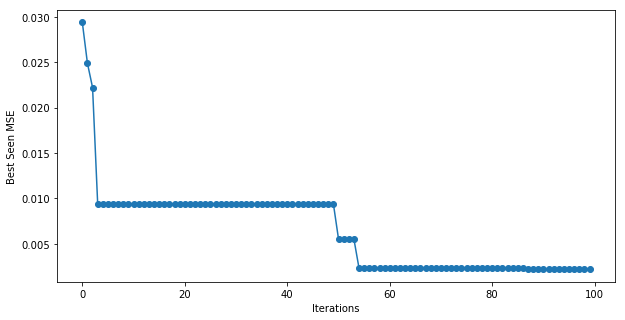

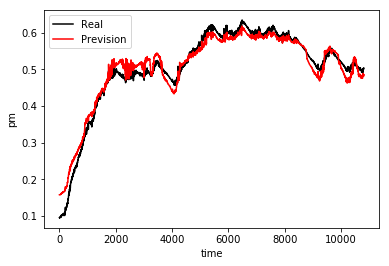

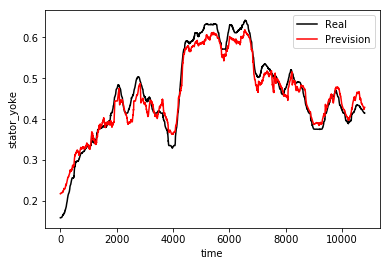

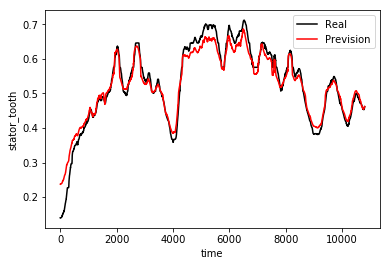

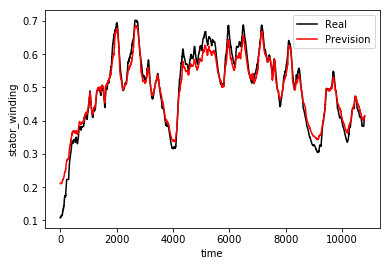

(Unnamed: 0               175
 Trial-ID                  88
 Status             COMPLETED
 Iteration                  1
 hidden                    39
 hidden1_pm                 3
 hidden1_stator             7
 hidden2_pm                 3
 hidden2_stator            20
 input_rec                  0
 lr                      0.01
 output_rec                 0
 window                     4
 Objective         0.00217289
 Name: 175, dtype: object, Custom_RNN(
   (dropout): Dropout(p=0.3, inplace=False)
   (layers): ModuleList(
     (0): Linear(in_features=50, out_features=39, bias=True)
   )
   (regressors): ModuleList(
     (0): Sequential(
       (0): Linear(in_features=39, out_features=3, bias=True)
       (1): ReLU()
       (2): Linear(in_features=3, out_features=3, bias=True)
       (3): ReLU()
       (4): Linear(in_features=3, out_features=1, bias=True)
     )
     (1): Sequential(
       (0): Linear(in_features=39, out_features=7, bias=True)
       (1): ReLU()
       (2): Linear(in_f

In [22]:
print_optimization_results(TRAIN_SET_TENSOR, VAL_SET_TENSOR,
                           "MSE", loss_fn=torch.nn.MSELoss(),
                           epochs=100)

In [23]:
## With a Custom Loss

1	0.03950
5	0.03553
6	0.03169
10	0.02653
13	0.02614
14	0.02612
16	0.02534
17	0.01171
18	0.01050
21	0.00909
24	0.00779
33	0.00518
62	0.00418

Best params:
Unnamed: 0               123
Trial-ID                  62
Status             COMPLETED
Iteration                  1
hidden                    39
hidden1_pm                18
hidden1_stator             7
hidden2_pm                 6
hidden2_stator             6
input_rec                  0
lr                      0.01
output_rec                 0
window                    13
Objective         0.00418331
Name: 123, dtype: object


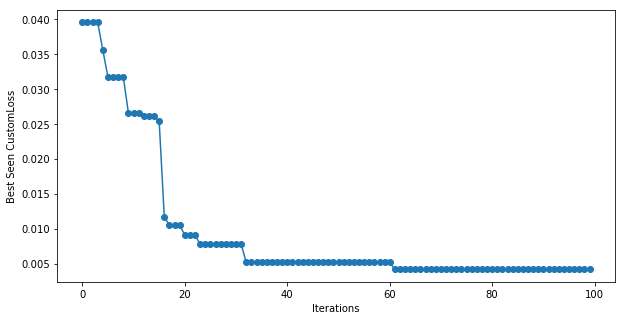

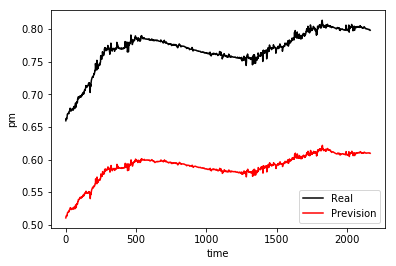

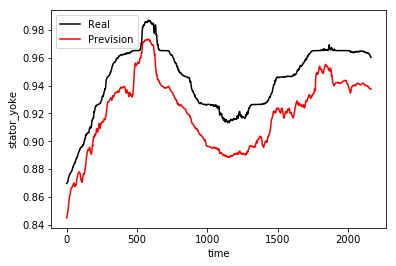

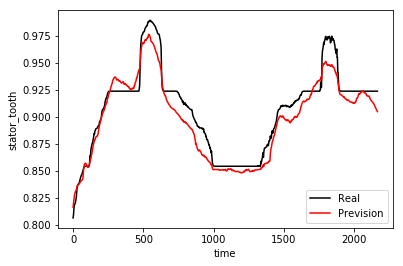

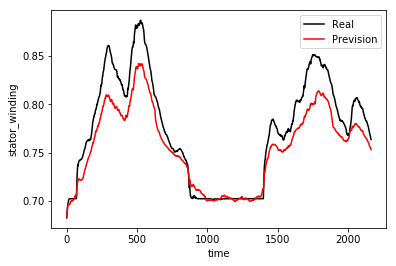

(Unnamed: 0               123
 Trial-ID                  62
 Status             COMPLETED
 Iteration                  1
 hidden                    39
 hidden1_pm                18
 hidden1_stator             7
 hidden2_pm                 6
 hidden2_stator             6
 input_rec                  0
 lr                      0.01
 output_rec                 0
 window                    13
 Objective         0.00418331
 Name: 123, dtype: object, Custom_RNN(
   (dropout): Dropout(p=0.3, inplace=False)
   (layers): ModuleList(
     (0): Linear(in_features=50, out_features=39, bias=True)
   )
   (regressors): ModuleList(
     (0): Sequential(
       (0): Linear(in_features=39, out_features=18, bias=True)
       (1): ReLU()
       (2): Linear(in_features=18, out_features=6, bias=True)
       (3): ReLU()
       (4): Linear(in_features=6, out_features=1, bias=True)
     )
     (1): Sequential(
       (0): Linear(in_features=39, out_features=7, bias=True)
       (1): ReLU()
       (2): Linear(in

In [24]:
def customLoss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1) * torch.nn.functional.relu(target - 0.5)
        return torch.mean(weights * ((output - target)**2))
    
    return high_low_loss


print_optimization_results(TRAIN_SET_TENSOR, VAL_SET_TENSOR,
                           "CustomLoss", loss_fn=customLoss(1, 3),
                           epochs=100)